In [532]:

# Yet Another CoViD LSTM Forecast

print('Loading Packages...')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten
from tensorflow.keras import regularizers
from keras.utils import plot_model
from ann_visualizer.visualize import ann_viz
from IPython.display import Image

print('Loading data...')
print('\n')

# Download data into a pandas dataframe
# This allows to get updated data
# Number of infected, number of recovered and number of deaths
covinft=pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
covrect=pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
covdeat=pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

# Get a numpy array of latitudes as a mean of latitudes by region
lat=pd.concat([covinft['Country/Region'],covinft['Lat']],axis=1).groupby(['Country/Region']).mean().T.to_numpy(copy=True)

# Get rid of unwanted data
del(covinft['Lat'])
del(covinft['Long'])
del(covinft['Province/State'])
del(covrect['Lat'])
del(covrect['Long'])
del(covrect['Province/State'])
del(covdeat['Lat'])
del(covdeat['Long'])
del(covdeat['Province/State'])

# Add cases by region to get total cases by country
covinfd=covinft.groupby(['Country/Region']).sum().T
covrecd=covrect.groupby(['Country/Region']).sum().T
covdead=covdeat.groupby(['Country/Region']).sum().T

# Dates and names of countries
index=np.array(covinfd.index)
columns=np.array(covrecd.columns)

# Infected, recovered, and deaths
# where each column of the matrices represents a country
# and each row represents a date
covinf=covinfd.to_numpy(copy=True)
covrec=covrecd.to_numpy(copy=True)
covdea=covdead.to_numpy(copy=True)

# Show one every seven dates
ticks=np.copy(index)
for i in range(0,len(index)):
    if i%7!=0:
        ticks[i]=''

# Get number of column given name of country
def countrynumber(country):
    return np.where(columns==country)[0][0]   

Loading Packages...
Loading data...




In [491]:
# Feature normalization
meaninf=np.mean(covinf);
stdinf=np.std(covinf);
meanrec=np.mean(covrec);
stdrec=np.std(covrec);
meandea=np.mean(covdea);
stddea=np.std(covdea);
meanlat=np.mean(lat);
stdlat=np.std(lat);

covinfn=(covinf-meaninf)/stdinf;
covrecn=(covrec-meanrec)/stdrec;
covdean=(covdea-meandea)/stddea;
latn=(lat-meanlat)/stdlat;

In [493]:
# Function to give shape to dataset with sliding window
# and multiple time steps of prediction
def create_dataset(dataset,look_back,look_forward):
    dataX,dataY=[],[]
    for j in range(len(dataset[0])):
        for i in range(len(dataset)-look_back-look_forward+1):
            dataX.append(dataset[i:(i+look_back),j])
            dataY.append(dataset[i+look_back:i+look_back+look_forward,j])
    return np.array(dataX),np.array(dataY)

In [494]:
# Randomly permute order of countries ans then divide dataset
# in countries in training and validation set
# (First dimension is date and second one is countries)
# stack creates third dimension including features
newcountryn=np.random.permutation(len(covinfn[0]))
dataset=np.stack((covinfn,covrecn,covdean),axis=-1)[:,newcountryn,:]
train_size=int(len(dataset[0])*0.7)
test_size=len(dataset[0])-train_size
train,test=dataset[:,0:train_size],dataset[:,train_size:len(dataset[0])]

In [495]:
# Create dataset with sliding window including the option
# for a feedforward network
look_back=21;
look_forward=1;

trainX,trainY=create_dataset(train,look_back,look_forward);
testX,testY=create_dataset(test,look_back,look_forward);

trainY=np.reshape(trainY,(trainY.shape[0],trainY.shape[1]*trainY.shape[2]));
testY=np.reshape(testY,(testY.shape[0],testY.shape[1]*testY.shape[2]));

trainXdense=np.reshape(trainX,(trainX.shape[0],trainX.shape[1]*trainX.shape[2]));
testXdense=np.reshape(testX,(testX.shape[0],testX.shape[1]*testX.shape[2]));

In [582]:
%%time

# Diverse hyperparameters
batch_size=train_size*(len(dataset)-look_back-look_forward+1)
units=48
epochs=300
regularization=4e-4
learning_rate=0.09
epsilon=0.2

# The neural net
model=Sequential()
LSTMobject=LSTM(units,input_shape=(look_back,3),return_sequences=False,kernel_regularizer=regularizers.l2(regularization))
model.add(LSTMobject)
#model.add(LSTM(24,kernel_regularizer=regularizers.l2(regularization)))
#model.add(Dropout(0.2))
model.add(Dense(3*look_forward))
opt = keras.optimizers.Adam(learning_rate=learning_rate,epsilon=epsilon)
model.compile(loss='mean_squared_error',optimizer=opt)
print(model.evaluate(trainX,trainY))
model.summary()
history=model.fit(trainX,trainY,validation_data=(testX,testY),epochs=epochs,batch_size=batch_size,verbose=2)

14279/14279 [==============================] - 2s 131us/step
1.5666069449634206
Model: "sequential_154"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_160 (LSTM)              (None, 48)                9984      
_________________________________________________________________
dense_197 (Dense)            (None, 3)                 147       
Total params: 10,131
Trainable params: 10,131
Non-trainable params: 0
_________________________________________________________________
Train on 14279 samples, validate on 6213 samples
Epoch 1/300
 - 2s - loss: 1.5666 - val_loss: 0.6274
Epoch 2/300
 - 2s - loss: 1.5168 - val_loss: 0.6046
Epoch 3/300
 - 2s - loss: 1.4731 - val_loss: 0.5802
Epoch 4/300
 - 2s - loss: 1.4282 - val_loss: 0.5545
Epoch 5/300
 - 2s - loss: 1.3894 - val_loss: 0.5276
Epoch 6/300
 - 2s - loss: 1.3535 - val_loss: 0.5007
Epoch 7/300
 - 2s - loss: 1.3197 - val_loss: 0.4750
Epoch 8/300
 - 2s

Epoch 141/300
 - 2s - loss: 0.1418 - val_loss: 0.0325
Epoch 142/300
 - 2s - loss: 0.1396 - val_loss: 0.0324
Epoch 143/300
 - 2s - loss: 0.1375 - val_loss: 0.0322
Epoch 144/300
 - 2s - loss: 0.1354 - val_loss: 0.0320
Epoch 145/300
 - 2s - loss: 0.1333 - val_loss: 0.0319
Epoch 146/300
 - 2s - loss: 0.1313 - val_loss: 0.0317
Epoch 147/300
 - 2s - loss: 0.1293 - val_loss: 0.0315
Epoch 148/300
 - 2s - loss: 0.1274 - val_loss: 0.0312
Epoch 149/300
 - 2s - loss: 0.1255 - val_loss: 0.0310
Epoch 150/300
 - 2s - loss: 0.1236 - val_loss: 0.0308
Epoch 151/300
 - 2s - loss: 0.1217 - val_loss: 0.0305
Epoch 152/300
 - 2s - loss: 0.1199 - val_loss: 0.0303
Epoch 153/300
 - 2s - loss: 0.1181 - val_loss: 0.0301
Epoch 154/300
 - 2s - loss: 0.1163 - val_loss: 0.0299
Epoch 155/300
 - 2s - loss: 0.1146 - val_loss: 0.0296
Epoch 156/300
 - 2s - loss: 0.1129 - val_loss: 0.0294
Epoch 157/300
 - 2s - loss: 0.1112 - val_loss: 0.0292
Epoch 158/300
 - 2s - loss: 0.1095 - val_loss: 0.0290
Epoch 159/300
 - 2s - loss: 

Epoch 293/300
 - 2s - loss: 0.0214 - val_loss: 0.0102
Epoch 294/300
 - 2s - loss: 0.0212 - val_loss: 0.0102
Epoch 295/300
 - 2s - loss: 0.0210 - val_loss: 0.0102
Epoch 296/300
 - 2s - loss: 0.0208 - val_loss: 0.0102
Epoch 297/300
 - 2s - loss: 0.0206 - val_loss: 0.0103
Epoch 298/300
 - 2s - loss: 0.0204 - val_loss: 0.0103
Epoch 299/300
 - 2s - loss: 0.0202 - val_loss: 0.0103
Epoch 300/300
 - 2s - loss: 0.0201 - val_loss: 0.0103
Wall time: 9min 57s


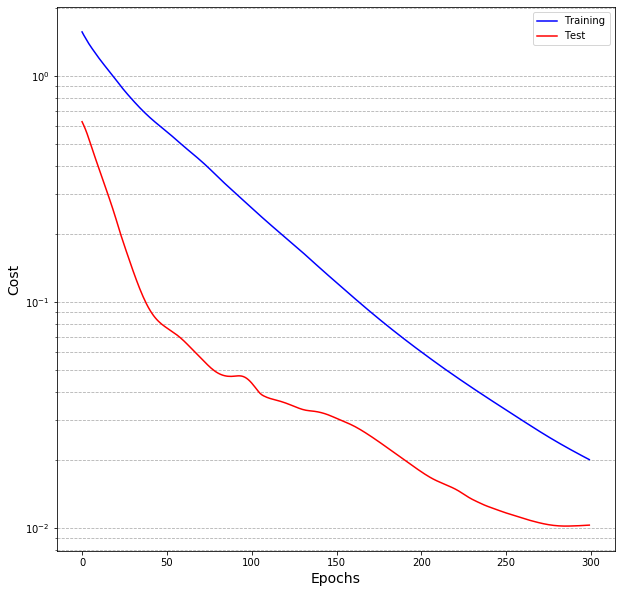

In [583]:
# Plot cost function as a function of epoch number
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'],'b',history.history['val_loss'],'r')
plt.legend(['Training','Test']);
plt.yscale("log");
plt.xlabel("Epochs", fontsize='14');
plt.ylabel('Cost',fontsize='14');
plt.grid(axis='y',linestyle='--',which='both');
plt.savefig('l_b='+str(look_back)+' l_f='+str(look_forward)+' units='+str(units)+' epochs='+str(epochs)+' b_size='+str(batch_size)+' regul='+str(regularization)+' l_rate='+str(learning_rate)+' eps='+str(epsilon)+'.png');
plt.show()

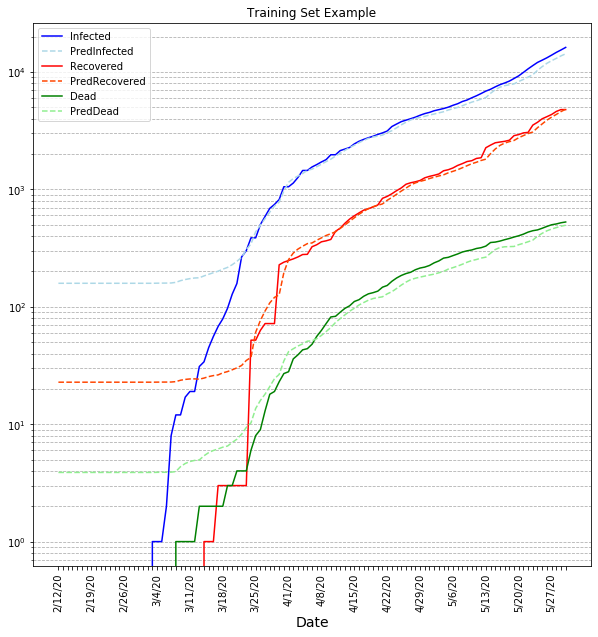

In [566]:
# Show fit for nth country in training set
# b is the number of days
b=(len(dataset)-look_back-look_forward+1)
n=1

# Model prediction and anti-normalization
yhat=model.predict(trainX[n*b:(n+1)*b])
yhat[:,0]=yhat[:,0]*stdinf+meaninf
yhat[:,1]=yhat[:,1]*stdrec+meanrec
yhat[:,2]=yhat[:,2]*stddea+meandea

# The plot
plt.figure(figsize=(10,10))
plt.plot(index[look_back:],covinf[look_back:,newcountryn[n]],'b')
plt.plot(yhat[:,0],'--', color='lightblue')
plt.plot(covrec[look_back:,newcountryn[n]],'r')
plt.plot(yhat[:,1],'--',color='orangered')
plt.plot(covdea[look_back:,newcountryn[n]],'g')
plt.plot(yhat[:,2],'--',color='lightgreen')
plt.xticks(index[look_back:],ticks[look_back:], rotation='vertical');
plt.xlabel("Date", fontsize='14');
plt.yscale("log")
plt.grid(axis='y',linestyle='--',which='both');
plt.legend(['Infected','PredInfected','Recovered','PredRecovered','Dead','PredDead']);
plt.title('Training Set Example');
plt.show()

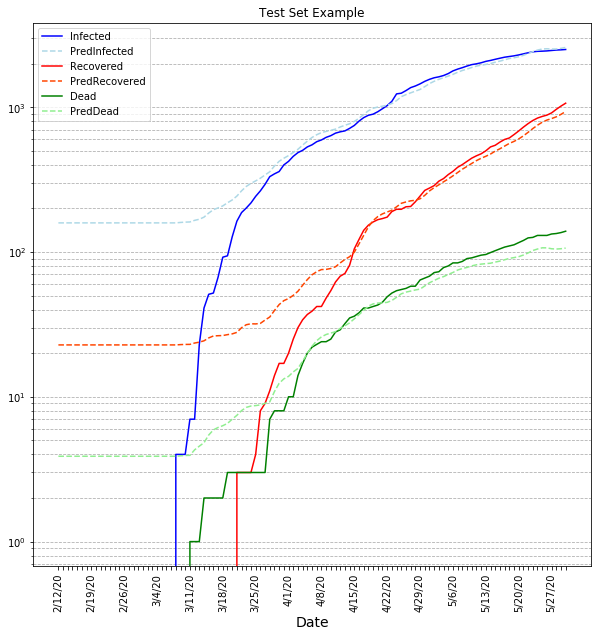

In [565]:
# Show fit for nth country in test set
# b is the number of days
b=(len(dataset)-look_back-look_forward+1)
n=1

# Model prediction and anti-normalization
yhat=model.predict(testX[n*b:(n+1)*b])
yhat[:,0]=yhat[:,0]*stdinf+meaninf
yhat[:,1]=yhat[:,1]*stdrec+meanrec
yhat[:,2]=yhat[:,2]*stddea+meandea

# The plot
plt.figure(figsize=(10,10))
plt.plot(index[look_back:],covinf[look_back:,newcountryn[n+train_size]],'b')
plt.plot(yhat[:,0],'--', color='lightblue')
plt.plot(covrec[look_back:,newcountryn[n+train_size]],'r')
plt.plot(yhat[:,1],'--',color='orangered')
plt.plot(covdea[look_back:,newcountryn[n+train_size]],'g')
plt.plot(yhat[:,2],'--',color='lightgreen')
plt.xticks(index[look_back:],ticks[look_back:], rotation='vertical');
plt.xlabel("Date", fontsize='14');
plt.yscale("log")
plt.grid(axis='y',linestyle='--',which='both');
plt.legend(['Infected','PredInfected','Recovered','PredRecovered','Dead','PredDead']);
plt.title('Test Set Example');
plt.show()